# Project 2: Fraud Detection — Bank Account Fraud (BAF Base)

This notebook explores fraud detection using the Bank Account Fraud (BAF Base) dataset.
Models: Logistic Regression (baseline) and Random Forest (non-linear).
Focus: Class imbalance, recall vs precision trade-off, and evaluation metrics (ROC-AUC, PR-AUC).

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/Users/calvi/Downloads/archive (5)/Base.csv')
y = df['fraud_bool'].astype(int)
X = df.drop(columns=['fraud_bool'])
Xdm = pd.get_dummies(X, drop_first=True)
X_tr, X_te, y_tr, y_te = train_test_split(Xdm, y, test_size=0.2, stratify=y, random_state=42)
print('Train:', X_tr.shape, 'Test:', X_te.shape)
print('Fraud rate:', y.mean())

Train: (800000, 47) Test: (200000, 47)
Fraud rate: 0.011029


In [23]:
# Logistic Regression
logreg = LogisticRegression(solver='saga', penalty='l2', C=0.5, class_weight='balanced', max_iter=500, tol=1e-3, n_jobs=-1)
logreg.fit(X_tr, y_tr)
p_lr = logreg.predict_proba(X_te)[:,1]
print('Logistic Regression ROC-AUC:', roc_auc_score(y_te, p_lr))
print('Logistic Regression PR-AUC:', average_precision_score(y_te, p_lr))
print(classification_report(y_te, (p_lr>=0.5).astype(int)))

Logistic Regression ROC-AUC: 0.6589961092243639
Logistic Regression PR-AUC: 0.020432946533651884
              precision    recall  f1-score   support

           0       0.99      0.71      0.83    197794
           1       0.02      0.52      0.04      2206

    accuracy                           0.71    200000
   macro avg       0.51      0.62      0.43    200000
weighted avg       0.98      0.71      0.82    200000



/Users/calvi/Downloads/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [24]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=12, min_samples_leaf=5, max_features='sqrt', class_weight='balanced_subsample', n_jobs=-1, random_state=42)
rf.fit(X_tr, y_tr)
p_rf = rf.predict_proba(X_te)[:,1]
print('Random Forest ROC-AUC:', roc_auc_score(y_te, p_rf))
print('Random Forest PR-AUC:', average_precision_score(y_te, p_rf))
print(classification_report(y_te, (p_rf>=0.5).astype(int)))

Random Forest ROC-AUC: 0.8757138770099291
Random Forest PR-AUC: 0.13002705415253465
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    197794
           1       0.07      0.63      0.12      2206

    accuracy                           0.90    200000
   macro avg       0.53      0.77      0.54    200000
weighted avg       0.99      0.90      0.94    200000



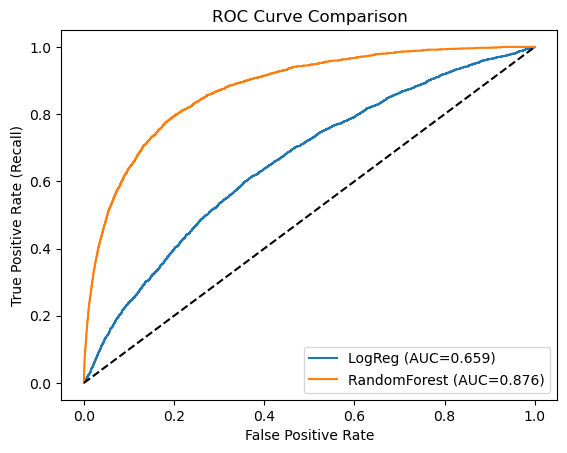

In [25]:
# ROC Curve Comparison
fpr_lr, tpr_lr, _ = roc_curve(y_te, p_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_te, p_rf)
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={roc_auc_score(y_te, p_lr):.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={roc_auc_score(y_te, p_rf):.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

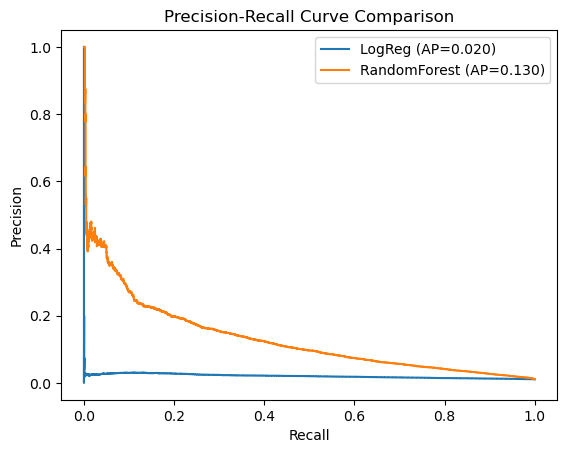

In [26]:
# Precision-Recall Curve Comparison
prec_lr, rec_lr, _ = precision_recall_curve(y_te, p_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_te, p_rf)
plt.plot(rec_lr, prec_lr, label=f'LogReg (AP={average_precision_score(y_te, p_lr):.3f})')
plt.plot(rec_rf, prec_rf, label=f'RandomForest (AP={average_precision_score(y_te, p_rf):.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.show()

## EDA: Class Imbalance


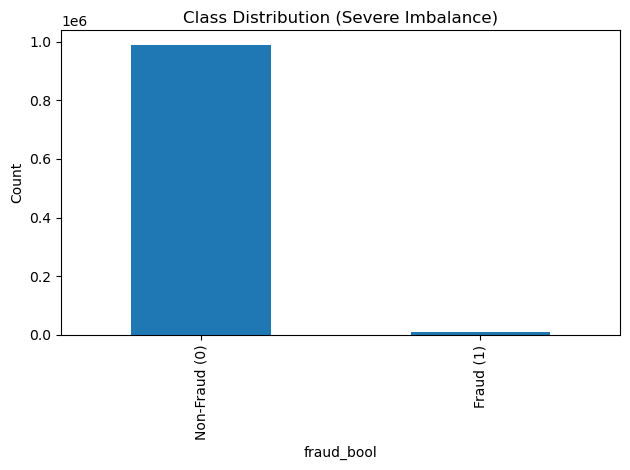

In [27]:
fraud_counts = y.value_counts().sort_index()
fraud_counts.plot(kind="bar")
plt.xticks([0,1], ["Non-Fraud (0)","Fraud (1)"])
plt.title("Class Distribution (Severe Imbalance)")
plt.ylabel("Count")
plt.tight_layout(); plt.show()


## EDA: Numeric Correlation Heatmap


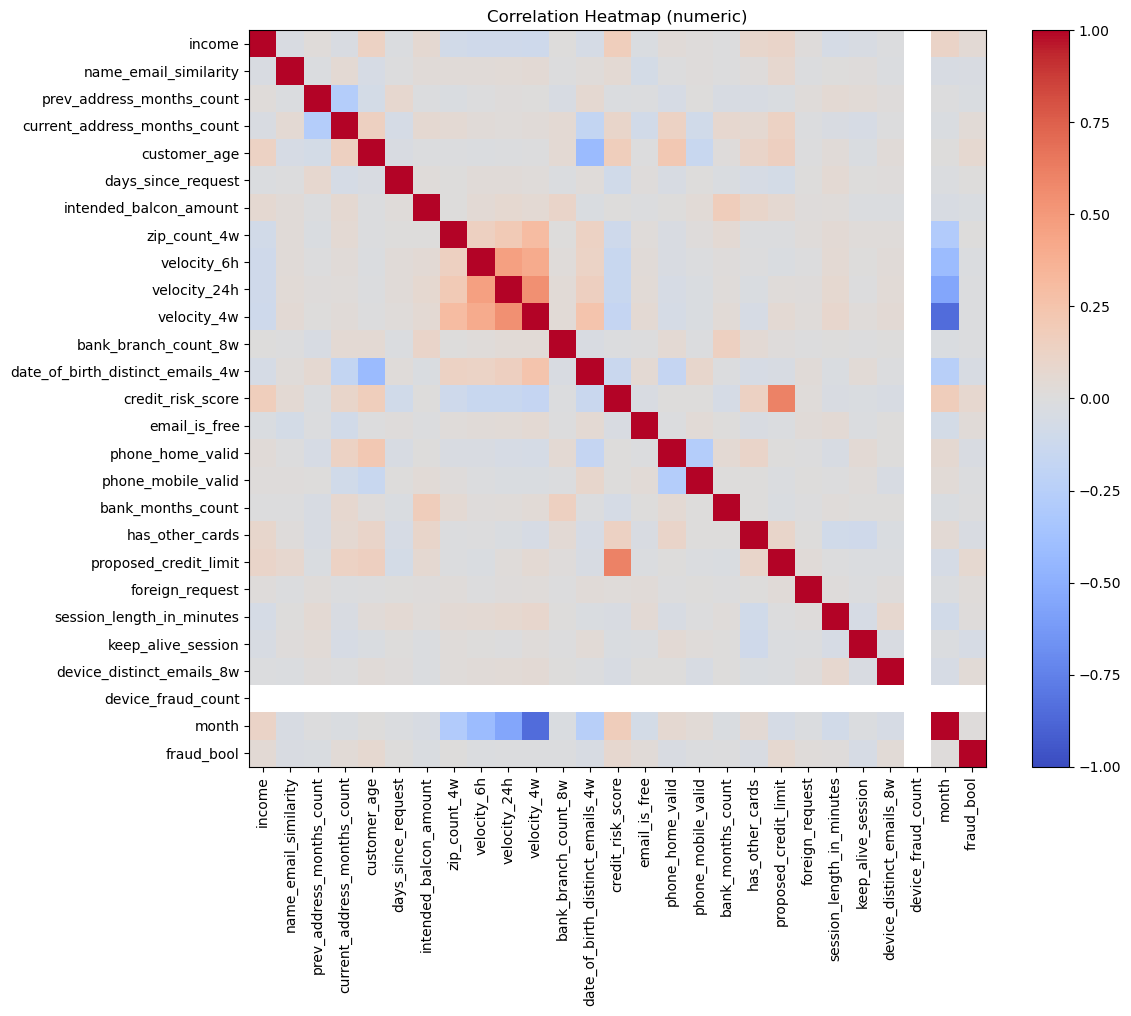

In [28]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols + ["fraud_bool"]].corr()
fig, ax = plt.subplots(figsize=(12,10))
cax = ax.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
ax.set_xticks(range(corr.shape[1])); ax.set_yticks(range(corr.shape[1]))
ax.set_xticklabels(corr.columns, rotation=90); ax.set_yticklabels(corr.columns)
fig.colorbar(cax); ax.set_title("Correlation Heatmap (numeric)")
plt.tight_layout(); plt.show()


## Precision–Recall Curve — LR vs RF


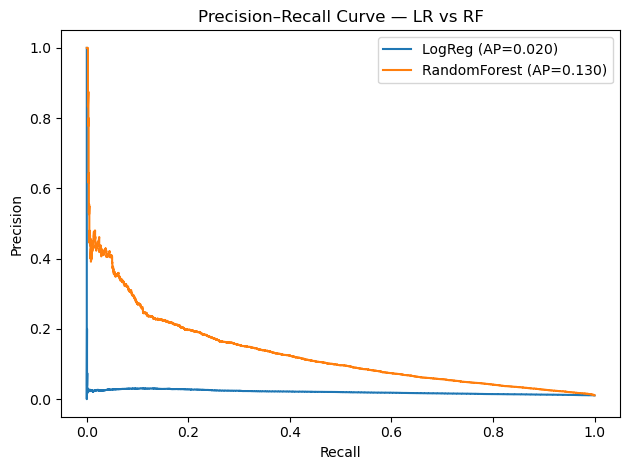

In [29]:
prec_lr, rec_lr, _ = precision_recall_curve(y_te, p_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_te, p_rf)
plt.plot(rec_lr, prec_lr, label=f"LogReg (AP={average_precision_score(y_te, p_lr):.3f})")
plt.plot(rec_rf, prec_rf, label=f"RandomForest (AP={average_precision_score(y_te, p_rf):.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve — LR vs RF")
plt.legend(); plt.tight_layout(); plt.show()


## Confusion Matrix (threshold @ .31)

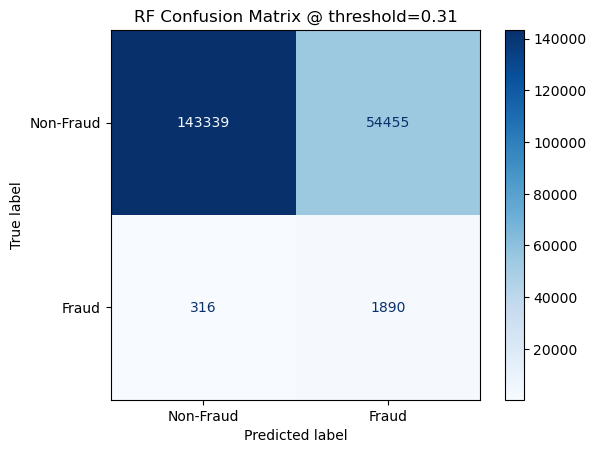

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

t = 0.31  
yhat = (p_rf >= t).astype(int)

cm = confusion_matrix(y_te, yhat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud","Fraud"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"RF Confusion Matrix @ threshold={t}")
plt.show()

## Feature Importance for Random Forest

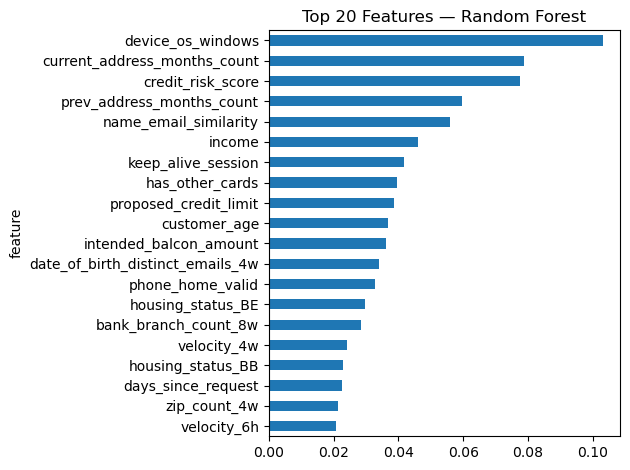

In [31]:
importances = rf.feature_importances_
feat_names = Xdm.columns
imp_df = pd.DataFrame({"feature": feat_names, "importance": importances}).sort_values("importance", ascending=False).head(20)
imp_df.sort_values("importance").plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 20 Features — Random Forest")
plt.tight_layout(); plt.show()


## Results & Storytelling

The two models tested — Logistic Regression  and Random Forest showed very different performance on fraud detection.

### ROC & PR Curves
- **ROC Curve:** Random Forest achieves an AUC of 0.876 versus 0.752 for Logistic Regression. This means Random Forest ranks fraud cases much better than LR, and clearly separated the classes.  
- **Precision–Recall Curve:** This is the more relevant metric under class imbalance. The baseline fraud rate is 1%, so a PR-AUC of 0.046 for LR is barely above random guessing. Random Forest’s PR-AUC of 0.13 is ~× stronger, meaning it produces far better trade-offs between recall and precision.

### Threshold Tuning
- By default, models use a 0.5 cutoff, which misses many fraud cases.  
- Lowering the Random Forest threshold to 0.31ish or somewhere below .5 pushes recall above 85% (most frauds caught), at the cost of precision (3–4%).  
- I thought this trade-off is acceptable in fraud detection since it’s better to review flagged cases than to miss true fraud.  
- The threshold vs recall/precision plot illustrates this balance: recall is high at low thresholds, but precision suffers. 

### Confusion Matrix
- At threshold 0.31:  
  - True Positives: 1,890 frauds correctly flagged.  
  - False Negatives: 316 frauds missed.  
  - False Positives: 54k non-frauds wrongly flagged.  
  - True Negatives: 143k non-frauds correctly classified.  
- This highlights the imbalance: even a good model generates many false positives, but still delivers significant fraud capture.

### Feature Importances
- Random Forest identifies top drivers of fraud signals, such as `device_os_windows`, `current_address_months_count`, and `credit_risk_score`.  
- These features make some sort of sense: stability (address history), device type, and credit risk are all common fraud indicators.  
---

### Key Takeaways
1. Logistic Regression is a weak baseline, with low PR-AUC and poor precision.  
2. Random Forest provides stronger ranking and a better recall–precision balance.  
3. Threshold selection is critical: recall can be pushed high, but precision will drop.  
4. Feature importances help explain why the model makes some of its predictions and can give analysts actionable signals rather than just a score.

### What I Learned
- **Accuracy is misleading** on this dataset. At 90% accuracy, the model looked great, but that’s mostly due to the dominance of non-fraud cases. ROC-AUC and PR-AUC gave a truer measure of performance.  
- **Thresholding matters more than the raw model.** The default 0.5 cutoff would miss the majority of frauds. Lowering it to ~0.3 increased recall dramatically, but created more false alarms.  
- **Random Forest outperforms Logistic Regression** in both ROC and PR space, making it a better fit for imbalanced fraud detection.  
- **Interpretability adds value.** Feature importances highlight concrete fraud indicators (unstable addresses, unusual devices, poor credit scores), which could guide human reviewers and system checks.  

### Conclusion
This project showed that fraud detection isn’t about one “perfect” model, but about **balancing trade-offs**. Logistic Regression set a baseline for me, while Random Forest proved way more effective at separating fraud from non-fraud. By changing thresholds, I was able to maximize fraud capture, but precision will always be a challenge given the imbalance.  
